# ```emcee```: the mcmc hammer

A quickstart on the [```emcee```library](https://emcee.readthedocs.io/en/stable/tutorials/quickstart/).

**Contents**
* [Quickstart](#Quickstart)
* [Fitting a model to data](#Fitting-a-model-to-data)
* [Results](#Results)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('astroph')

In [3]:
np.random.seed(42)

### Quickstart

[**&uarr; Return to contents**](#emcee:-the-mcmc-hammer)

We want to draw samples from a multivariate (N-dimensional) gaussian density:
$$
p(\vec{x}) \propto \exp \left [ - \frac{1}{2} (\vec{x} -
    \vec{\mu})^\mathrm{T} \, \Sigma ^{-1} \, (\vec{x} - \vec{\mu})
    \right ]
$$


In [4]:
def log_prob(x, mu, cov):
    vec = x - mu
    return -0.5*np.dot(vec, np.linalg.solve(cov,vec))

In [5]:
ndim = 5

In [6]:
means = np.random.rand(ndim)

In [7]:
cov  = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim)) 
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal()) # simmetry
cov = np.dot(cov, cov) # positive-definiteness

In [8]:
nwalkers = 32

In [9]:
p0 = np.random.rand(nwalkers, ndim)

In [10]:
p0.shape

(32, 5)

In [11]:
import emcee

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

*Burn-in step*

In [13]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

*Sampling*

In [14]:
sampler.run_mcmc(state, 10**4);

In [15]:
samples = sampler.get_chain(flat=True)

In [16]:
samples.shape

(320000, 5)

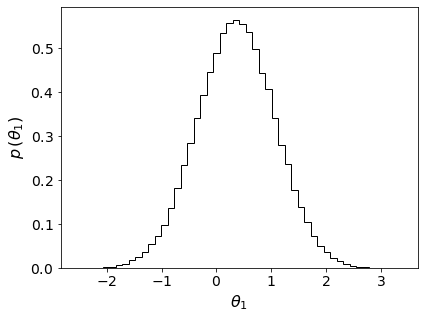

In [17]:
plt.hist(samples[:, 0], bins=50, color='k', histtype='step', density=True)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r'$p\,(\theta_1)$')
plt.show()

In [18]:
np.mean(sampler.acceptance_fraction)

0.552271875

In [19]:
np.mean(sampler.get_autocorr_time())

57.11155556661981

## Fitting a model to data

[**&uarr; Return to Contents**](#emcee:-the-mcmc-hammer)

When you approach a new problem, the first step is generally to write down a *likelihood function*. This is equivalent to describing the generative procedure for the data (simulation generated data has lots of latent variables and describe their production may be unfeasible &rarr; *simulation-based inference* or *likelihood-free inference*).

In [20]:
m_true = -0.9594
b_true = 4.294
f_true = 0.534

In [21]:
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N) 

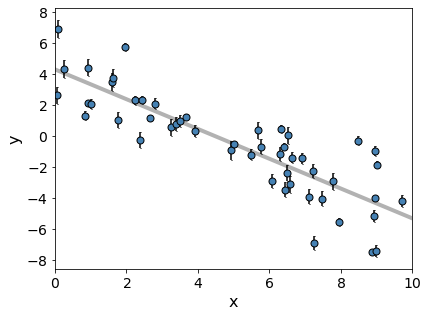

In [22]:
plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=7, capsize=0.5, color='k', mfc='steelblue')
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=4)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

### Least-Squares

In [23]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))

In [24]:
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

m = -0.922 ± 0.013
b = 3.897 ± 0.077


#### Via 'Normal Equation*

**Note**: this is equivalent to the previous procedure only if the noise is gaussian. This is obviously not true here!

In [25]:
x_bias = np.c_[np.ones(x.size), x]

In [26]:
coef = np.linalg.inv(x_bias.T.dot(x_bias)).dot(x_bias.T).dot(y)

In [27]:
coef

array([ 4.22306885, -0.95262554])

In [28]:
np.polyfit(x, y, deg=1)

array([-0.95262554,  4.22306885])

*Plotting*

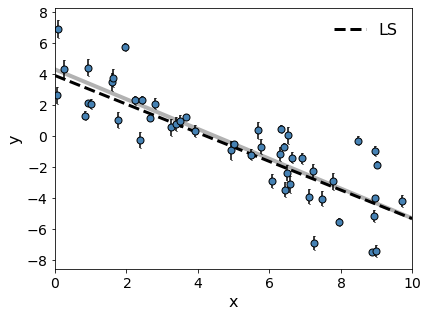

In [29]:
plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=7, capsize=0.5, color='k', mfc='steelblue')
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=4)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", lw=3, label="LS")
plt.legend(frameon=False)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

### Maximum likelihood estimation

We know that the least-squares is not right, because it is based on the assumption of error normality and independence. Instead, we seek to maximize the model likelihood:

$$
\ln\,p(y\,|\,x,\sigma,m,b,f) =
-\frac{1}{2} \sum_n \left[
    \frac{(y_n-m\,x_n-b)^2}{s_n^2}
    + \ln \left ( 2\pi\,s_n^2 \right )
\right]
$$

where

$$s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2$$

Let's explore the way we produced our synthetic dataset and establish the relations between our generative procedure and the likelihood:

* The true function is a linear response on x:

```python
y = m_true * x + b_true
``` 
* Now we add the 'understimation factor' of the variance $f$.

```python
y += np.abs(f_true * y) * np.random.randn(N)
```

This is equivalent to adding a gaussian noise with distribution $\varepsilon_i \sim \mathcal{N} \left(0, f^2 (b + x_i)^2 \right)$.

* And finally:

```python
y += yerr * np.random.randn(N) 
```

This is equivalent to adding a gaussian noise with distribution $\epsilon_i \sim \mathcal{N} \left(0, \sigma^2 \right)$, where $\sigma$ is the 'intrinsic variance' of the data.

In [30]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

**Using ```scipy.optimize```**

In [31]:
from scipy.optimize import minimize

Maximizing the log-likelihood is equal to minimizing its opposite.

In [32]:
nll = lambda *args: -log_likelihood(*args)

Create a initial guess around the true values.

In [33]:
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)

In [34]:
soln = minimize(nll, initial, args=(x, y, yerr))

In [35]:
m_ml, b_ml, log_f_ml = soln.x

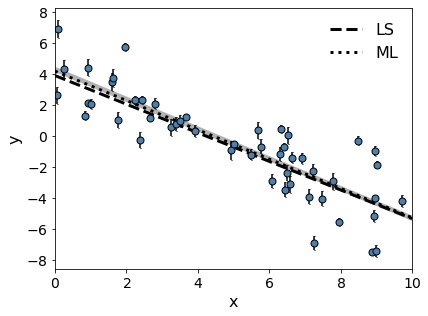

In [36]:
plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=7, capsize=0.5, color='k', mfc='steelblue')
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=5)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", lw=3, label="LS")
plt.plot(x0, m_ml*x0 + b_ml, ':', color='k', lw=3, label='ML')
plt.legend(frameon=False)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

But we have no uncertainty estimation! That's where MCMC comes in handy. 

### Marginalization & uncertainty estimation

By Bayes Theorem, we know that the posterior is:

$$ p (m,b,f\,|\,x,y,\sigma) \propto p(m,b,f)\,p(y\,|\,x,\sigma,m,b,f) $$

but we already know the likelihood $p(y\,|\,x,\sigma,m,b,f) $, so the missing component is the *prior*:

$$ p(m,b,f)$$

This function encodes any previous knowledge we might have about the parameters: results from other experiments, physically acceptable ranges. Notice that it doesn't make sennse to sample parameters from the likelihood as it is a propability distribtuion over the datasets (as we said, it describes the generative procedure of the data). Instead, what makes sense is sampling a distribution on the *parameters*, as the posterior and the prior.

We'll use uniform (or 'uninformative') priors on $m, b$ and $\log{f}$. For example, on $m$:

$$ f (m) = 
\begin{cases}
\frac{1}{5.5}, &\quad \mathrm{if} -5< m < 1/2 \\
0, &\quad \mathrm{otherwise} \\
\end{cases}
$$

Up to a constant, we can define the log-prior:

In [37]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 10.0:
        return 0.0
    else:
        return -np.inf

The log-posterior will, then, be:

In [38]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

**Initializing the chain**

We'll initiliaze the walkers on a ball around the ML result obtained in the previous minimization procedure.

In [39]:
pos = soln.x + 1e-4*np.random.randn(nwalkers, 3)

In [40]:
nwalker, ndim = pos.shape

In [41]:
sampler = emcee.EnsembleSampler(nwalker, ndim, log_probability, args=(x,y, yerr))

In [42]:
sampler.run_mcmc(pos, 5*10**3, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 833.28it/s]


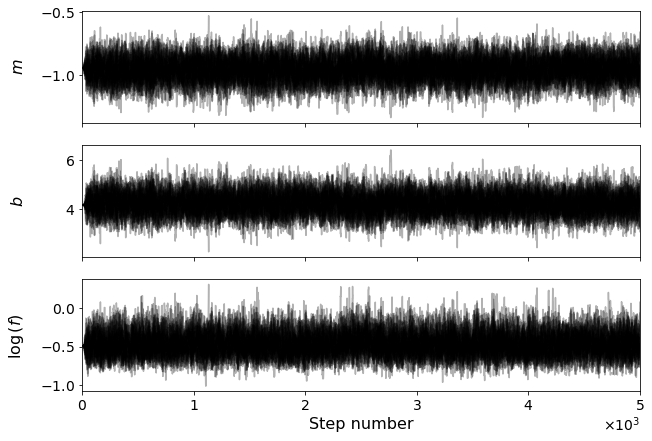

In [43]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r'$m$', r'$b$', r'$\log{\,(f)}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k',  alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel('Step number')
plt.show()

Discard the initial 100 steps and thining at a step of $\sim$ half of the autocorrelation time.

In [44]:
tau = sampler.get_autocorr_time()
print(tau)

[38.45547226 38.5709912  35.83330999]


In [45]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


## Results

[**&uarr; Return to Contents**](#emcee:-the-mcmc-hammer)

In [47]:
import corner

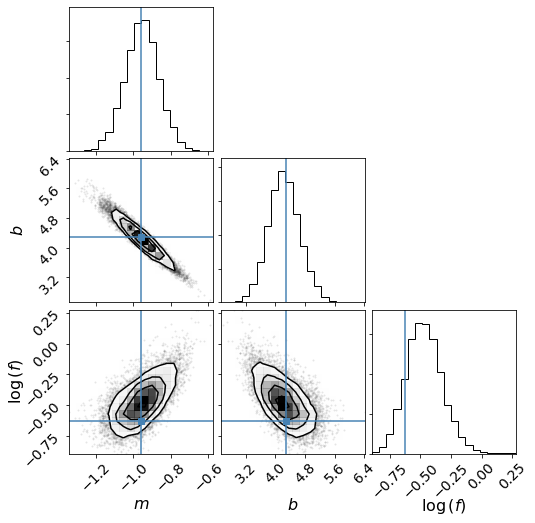

In [48]:
fig = corner.corner(flat_samples,  labels=labels, truths=[m_true, b_true, np.log(f_true)]);

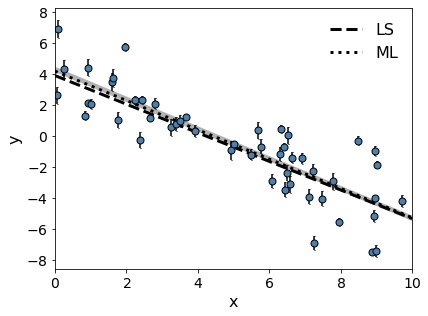

In [49]:
plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=7, capsize=0.5, color='k', mfc='steelblue')
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=5)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", lw=3, label="LS")
plt.plot(x0, m_ml*x0 + b_ml, ':', color='k', lw=3, label='ML')
plt.legend(frameon=False)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

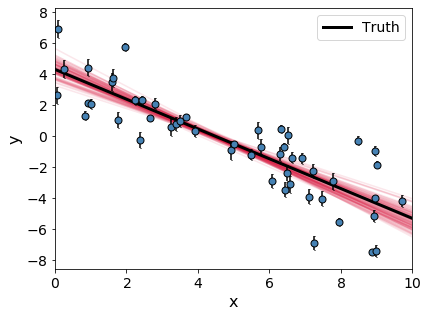

In [50]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", color='crimson', alpha=0.1, zorder=-1)
plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=7, capsize=0.5, color='k', mfc='steelblue')
plt.plot(x0, m_true * x0 + b_true, "k", alpha=1, lw=3, label='Truth')
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [51]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i].split('$')[1:-1][0])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>